In [5]:
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
import os
import re
import random
import time
import numpy as np
import pandas as pd
options = webdriver.ChromeOptions()
options.binary_location = os.environ.get( "GOOGLE_CHROME_BIN")
options.add_argument("--headless")
options.add_argument("--disable-dev-shm-usage")
options.add_argument("--no-sandbox")
options.add_argument("start-maximized");
options.add_experimental_option('excludeSwitches', ['enable-logging'])
driver = webdriver.Chrome(options=options)
driver = webdriver.Chrome(executable_path='path\to\chromedriver_win32_2.0')
driver.get("https://sacramento.craigslist.org/search/cta")

In [2]:
#we took our data from :

#the urls we are scraping from :
site_urls = ["https://losangeles.craigslist.org/search/cta","https://sfbay.craigslist.org/search/cta",
             "https://sandiego.craigslist.org/search/cta", "https://sacramento.craigslist.org/search/cta"]

In [3]:
html = driver.page_source
soup = BeautifulSoup(html)

In [6]:
cylinders = []
drive=[]
year = []
odometer = []
price = []
paint = []
transmission = []
manufacture = []
fuel = []
other_parameters = []



In [5]:
# the amount of pages we need to run over - scraping the number of total ads , dividing it by 120 ads per page equals 
# for the real page amount

page_numbers = soup.find("span", attrs={"class" : "cl-page-number"}).get_text()

i = len(page_numbers) - 1
j = 0

while i >=0:
    if page_numbers[i] == ',' or (page_numbers[i]).isnumeric():
        i = i-1
        index = i
    else:
        break
index = index + 1
while index < len(page_numbers):
    if page_numbers[index] != ',':
        digit = int(page_numbers[index])
        j=j*10
        j= j + digit
        
    index = index + 1
    
real_num_pages = int(j / 120) # 120 results each page

In [6]:
# most common car brands:

manufacturer = '(gmc | hyundai | toyota | mitsubishi | ford | chevrolet | ram | buick | jeep | dodge | subaru | nissan | audi | rover  | lexus \
| honda | chrysler | mini | pontiac | mercedes| cadillac | bmw | kia | volvo | volkswagen | jaguar | acura | saturn | mazda | \
mercury | lincoln | infiniti | ferrari | fiat | tesla | land | datsun | alfa | morgan | aston | porche \
| hennessey | suzuki | vw | maserati | bentley | lamborghini | peugeot | citroen | saab | mclaren | byd | polestar | mg)'

In [7]:
# this function returns the name of the manufacturer, might be in two different places in the string

def manufacture_name(string):
    space_counter = 0
    first_string = ""
    second_string = ""
    index = 0
    space_counter = 0
    
    while string[index] != ' ':
        
        first_string = first_string + string[index]
        index = index + 1
        
        if string[index] == ' ':
            space_counter = space_counter + 1 
            break
            
    index = index + 1 #get over the first space
    
    while string[index] != ' ' and space_counter != 2 and index < len(string):
        second_string = second_string + string[index]
        index = index + 1
        
        if string[index] == ' ':
            space_counter = space_counter + 1 
            break
            
    return first_string.lower(),second_string.lower()

In [8]:
# this is the main scraping and crawling stage

pages = 0
counter_car = 0

while pages < real_num_pages:
    
    ol = soup.find("div", attrs={"class" : "cl-search-results"}).find("ol") #get the order list that contains each car
    list_items = ol.findAll("li", attrs={"class" : "cl-search-result cl-search-view-mode-gallery"}) #each li item which is a picture
    
    for item in list_items: #run on all the cars in this page
        
        try:
            url = item.find("a", attrs={"class" : "main"})['href'] # getting the image html inside each li item
            
            time.sleep(random.randint(2,7)) # to avoid server overloading
            
            response = requests.get(url) 
            
            soup2 = BeautifulSoup(response.content, "html.parser") #getting the html of each car
            
            deleted_page = soup2.find("div", attrs={"class" : "removed"}) #sometimes people delete their posts but for some reason it still appears in the site
            
            if deleted_page != None:
                continue
        except Exception as e:
            continue
        
        try:
            error_page = soup2.find("section", attrs={"class" : "simple-page-content"}).findAll("p") #soup2 can return error page loading so checking it, if so continue the loop
            
            for i in error_page:
                if i.get_text() == "404 Error":
                    continue
        except Exception as e:
               pass    
        #getting the name of the manufacturer :
        
        try:
            manufacture_data = item.find("a", attrs={"class" : "titlestring"}).get_text()
            manufacture_data1, manufacture_data2  = manufacture_name(manufacture_data)
            
            if manufacture_data1 in manufacturer: #if that's any name that we need, then take it otherwise dont take it
                manufacture.append(manufacture_data1)
            
            elif manufacture_data2 in manufacturer:
                manufacture.append(manufacture_data2)
            
            else:
                manufacture.append(np.nan)
        
        except Exception as e:
            manufacture.append(np.nan)
        
        try: # if no price was given in the ad
            
            data_price = item.find("span", attrs={"class" : "priceinfo"}).get_text().replace("$","").replace(",","") #getting the price
            price.append(data_price)
        
        except Exception as e:
            price.append(np.nan)
        
        try:
            year_parameter = soup2.find("div", attrs={"class" : "mapAndAttrs"}).findAll("p", attrs={"class" : "attrgroup"})[0]
            year.append(re.findall("\d+", year_parameter.b.get_text())[0]) #getting the number from the string
        
        except Exception as e:
            year.append(np.nan)
        
        try:        
            other_parameters = soup2.find("div", attrs={"class" : "mapAndAttrs"}).findAll("p", attrs={"class" : "attrgroup"})[0].findAll("span")
        
        except Exception as e:
            pass
        
        try:
            other_parameters = soup2.find("div", attrs={"class" : "mapAndAttrs"}).findAll("p", attrs={"class" : "attrgroup"})[1].findAll("span")
        
        except Exception as e:
            pass
        
        
        t1,t2,t3,t4,t5,t6 = 0,0,0,0,0,0
        
        for param in other_parameters: #all the other parameters except year, those parameters inside each picture  
            try:
                if "cylinders" in  param.get_text() and param.b.get_text() !='':
                    cylinders.append( re.findall("\d+", param.b.get_text())[0] )
                    t1 = 1
            except Exception as e:
                if t1 == 0:
                    cylinders.append(np.nan)
                    t1=1
            try:
                if "drive" in param.get_text():
                    if( param.b.get_text() == "fwd"):
                        drive.append("fwd")
                        t2 = 1
                   
                    elif param.b.get_text() == "rwd":
                        drive.append("rwd")
                        t2 = 1
                    
                    elif param.b.get_text() == "4x4":
                        drive.append("4x4")
                        t2 = 1
                    
                    elif param.b.get_text() == "awd":
                        drive.append("awd")
                        t2 = 1
                    
                    elif param.b.get_text() == "4wd":
                        drive.append("4wd")
                        t2 = 1

            except Exception as e: #sometimes missing string for drive 
                if t2 == 0:
                    drive.append(np.nan)
                    t2=1

            try: #sometimes people fail to fill the odometer cell
                
                if "odometer" in param.get_text() and param.b.get_text() !='':
                    odometer.append( param.b.get_text() )
                    t3 = 1
            
            except Exception as e:
                if t3 == 0:
                    odometer.append(np.nan)
                    t3=1
            
            try:
                if "paint" in param.get_text():
                    paint.append( param.b.get_text())
                    t4 = 1
            
            except Exception as e:
                if t4 == 0:
                    paint.append(np.nan)
                    t4 = 1
            
            try:
                if "transmission" in param.get_text():
                    if param.b.get_text() == "automatic":
                        transmission.append(0)
                        t5 = 1
                    
                    elif param.b.get_text() !='':
                        transmission.append(1)
                        t5 = 1
            
            except Exception as e:
                if t5 == 0:
                    transmission.append(np.nan)
                    t1 = 1
            
            try:
                if "fuel" in param.get_text() and param.b.get_text()!='':
                    if (param.b.get_text() == 'gas') or (param.b.get_text() == 'diesel'):
                        fuel.append(0)
                        t6=1
                    else:
                        fuel.append(1)
                        t6=1
            
            except Exception as e:
                if t6 == 0:
                    fuel.append(np.nan)
                    t6 = 1
        
        #checking if we need to append nan, so the arrays will be in the same length and if no exception was thrown
        if( t1 == 0):  
            cylinders.append(np.nan)
        
        if( t2 == 0):
            drive.append(np.nan)
        
        if( t3 == 0):
            odometer.append(np.nan)
        
        if( t4 == 0):
            paint.append(np.nan)
        
        if( t5 == 0):
            transmission.append(np.nan)
        
        if t6 == 0 :
            fuel.append(np.nan)
        
        if len(year) != len(fuel) and len(manufacture) != len(fuel) and len(price) != len(fuel): #if that took only the year or none of the above
            manufacture.pop(len(manufacture)-1)
            price.pop(len(price)-1)
            year.pop(len(pop)-1)
        
        counter_car = counter_car + 1      
    
    time.sleep(random.randint(2,7)) # to avoid server overloading
    
    driver.find_element(By.CSS_SELECTOR, "button.bd-button.cl-next-page.icon-only").click() # clicking on the next page button
    
    html = driver.page_source 
    
    soup = BeautifulSoup(html) #getting the html file of the next page
    
    pages = pages + 1#incrementing the pages counter
    
    

In [72]:
def load_csv(file_name):
    return pd.read_csv(file_name)

In [73]:
# creating the dataframe

#df2 = pd.DataFrame({"year" : year, "odometer" : odometer, "cylinders" :cylinders, "fuel":fuel,"manufacture":manufacture,"drive":drive,"paint":paint,"price":price,"transmission":transmission})

In [74]:
# the way to transfer data to csv file :

#df2.to_csv("last_used_Cars_Sacramento.csv", index=False, na_rep="NaN")

In [75]:
# 4th site we scraped:

df2 = load_csv("last_used_Cars_Sacramento.csv")

In [76]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9913 entries, 0 to 9912
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          9886 non-null   float64
 1   odometer      9889 non-null   float64
 2   cylinders     4994 non-null   float64
 3   fuel          9859 non-null   float64
 4   manufacture   8353 non-null   object 
 5   drive         7311 non-null   object 
 6   paint         6439 non-null   object 
 7   price         9103 non-null   float64
 8   transmission  9743 non-null   float64
dtypes: float64(6), object(3)
memory usage: 697.1+ KB


In [77]:
# combination of the first 3 sites we've scraped from :

df = load_csv("Last_used_cars.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26803 entries, 0 to 26802
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          26787 non-null  float64
 1   odometer      26373 non-null  float64
 2   cylinders     15499 non-null  float64
 3   fuel          26780 non-null  float64
 4   manufacture   21660 non-null  object 
 5   drive         18535 non-null  object 
 6   paint         16458 non-null  object 
 7   price         24434 non-null  float64
 8   transmission  26751 non-null  float64
dtypes: float64(6), object(3)
memory usage: 1.8+ MB


In [78]:
df.head()

,year,odometer,cylinders,fuel,manufacture,drive,paint,price,transmission
0,2013.0,104246.0,4.0,1.0,ford,fwd,NaN,136.0,0.0
1,2014.0,125834.0,4.0,0.0,honda,fwd,NaN,155.0,0.0
2,2015.0,94933.0,6.0,0.0,infiniti,rwd,NaN,17995.0,0.0
3,2017.0,64265.0,4.0,0.0,hyundai,fwd,NaN,11995.0,0.0
4,2018.0,39101.0,4.0,0.0,nissan,fwd,NaN,16495.0,0.0


In [79]:
# combining the above two data frames

In [80]:
list1 = ['year', 'odometer', 'cylinders','fuel','manufacture','drive','paint','price','transmission']

result1 = pd.concat([df,df2], axis=0 , join='inner')

In [81]:
result1 = result1.reset_index(drop=True)

result1

,year,odometer,cylinders,fuel,manufacture,drive,paint,price,transmission
0,2013.0,104246.0,4.0,1.0,ford,fwd,NaN,136.0,0.0
1,2014.0,125834.0,4.0,0.0,honda,fwd,NaN,155.0,0.0
2,2015.0,94933.0,6.0,0.0,infiniti,rwd,NaN,17995.0,0.0
3,2017.0,64265.0,4.0,0.0,hyundai,fwd,NaN,11995.0,0.0
4,2018.0,39101.0,4.0,0.0,nissan,fwd,NaN,16495.0,0.0
...,...,...,...,...,...,...,...,...,...
36711,2014.0,262098.0,8.0,0.0,NaN,rwd,white,15750.0,0.0
36712,2008.0,124064.0,NaN,0.0,toyota,fwd,black,13999.0,0.0
36713,2007.0,200009.0,NaN,0.0,toyota,NaN,NaN,6400.0,0.0
36714,2016.0,150000.0,NaN,0.0,chevrolet,NaN,NaN,6300.0,0.0


In [82]:
#let's see how to data looks:

In [83]:
import matplotlib as mpl
import matplotlib.pyplot as plt      
import seaborn as sns
from collections import Counter
from sklearn.decomposition import PCA
%matplotlib inline

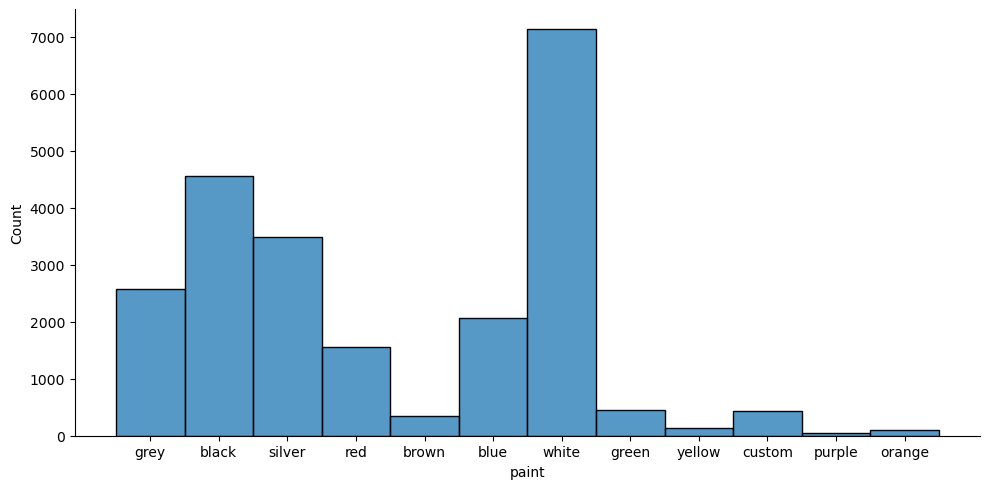

In [91]:
sns.displot(result1, x="paint", height=5, aspect=2)


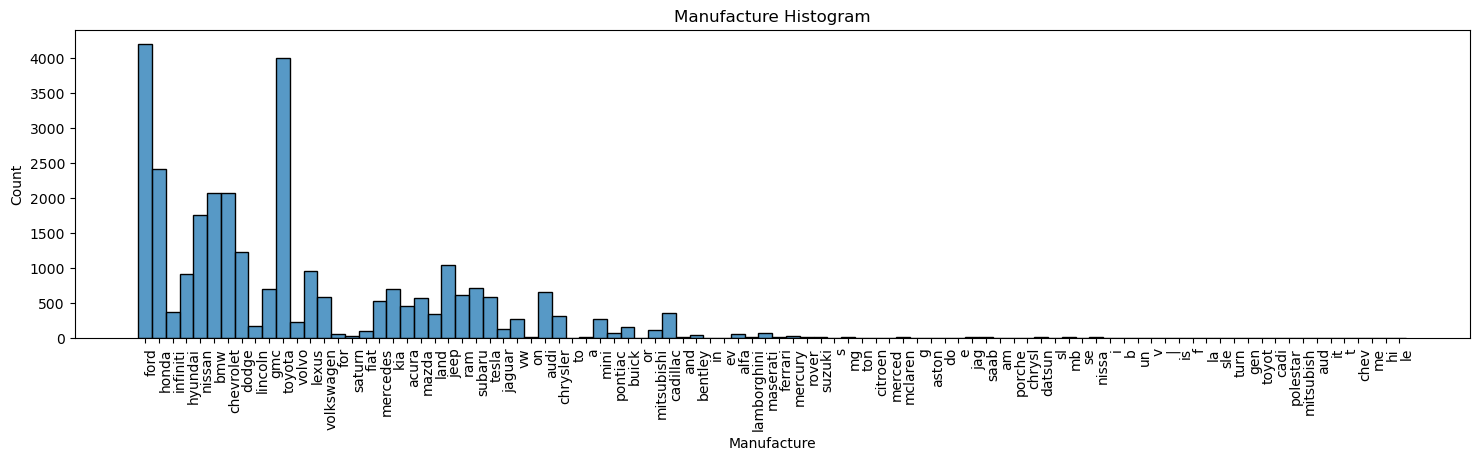

In [92]:
fig, ax = plt.subplots(figsize=(18,4))
fg = sns.histplot(result1['manufacture'], ax=ax)
fg.set_title("Manufacture Histogram")
fg.set_xlabel("Manufacture")
plt.xticks(rotation=90, ha='right', rotation_mode = 'anchor')
plt.show()

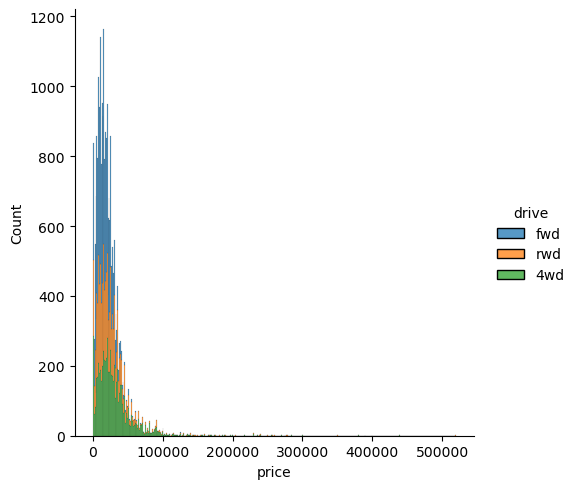

In [93]:
sns.displot(result1, x="price", hue='drive', multiple="stack")

In [94]:
# the next stage is handling missing values:

In [84]:
df1 = result1.copy()

# if there is no manufacture name we can delete it:
df1.dropna(subset=['manufacture'], inplace=True)

# transmission :  missing values in transmission will be filled with 1 = manual
df1['transmission']=df1['transmission'].fillna(1)

freq_color = df1['paint'].mode()[0] #the most frequent color on the paint column

# color, fill with the most common ( turns out it is white)
df1['paint'] = df1['paint'].fillna(freq_color)

# odometer, fill with average = mean
#df1['odometer'].fillna(df1['odometer'].mean(),inplace=True) #fill odometer with the average of odometer
df1.dropna(subset=['odometer'],inplace=True)

# missing year:  remove this vehicle
df1.dropna(subset=['year'],inplace=True)

#missing price: remove the vehicle
df1.dropna(subset=['price'], inplace=True)

# adding the 1 value to electric cars:
df1["fuel"] = df1["fuel"].fillna(df1['manufacture'].map({"tesla" : 1, "polestar" : 1, "byd" : 1})) #adding electric value to electric cars that lack the fuel section

# missing fuel:  fill with 0 ( equals to internal combustion engine)
df1["fuel"] = df1["fuel"].fillna(0)

# car owner that fail to fill the drive section , usually have fwd which has lower price than rwd or 4x4
df1['drive'] = df1['drive'].fillna("fwd")

In [85]:
# it is hard to determine how many cylinders each car has , however , we can fill each car's cylinder number by 
# the number of cylinders of the "drive's" most frequent value: 

In [86]:
df1.groupby(['drive','cylinders']).cylinders.count()

drive  cylinders
4wd    3.0            11
       4.0          1051
       5.0            14
       6.0          1851
       8.0          1323
       10.0           14
       12.0           14
fwd    3.0            36
       4.0          5077
       5.0            70
       6.0          2223
       8.0           481
       10.0           26
       12.0            6
rwd    3.0             1
       4.0           645
       5.0            25
       6.0          1403
       8.0          1429
       10.0           50
       12.0            8
Name: cylinders, dtype: int64

In [87]:
df1["cylinders"] = df1["cylinders"].fillna(df1['drive'].map({"4wd" : 6,"fwd" : 4, "rwd" : 8}))

df1=df1.reset_index(drop=True)

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27150 entries, 0 to 27149
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          27150 non-null  float64
 1   odometer      27150 non-null  float64
 2   cylinders     27150 non-null  float64
 3   fuel          27150 non-null  float64
 4   manufacture   27150 non-null  object 
 5   drive         27150 non-null  object 
 6   paint         27150 non-null  object 
 7   price         27150 non-null  float64
 8   transmission  27150 non-null  float64
dtypes: float64(6), object(3)
memory usage: 1.9+ MB


In [88]:
def outlier_detection_iqr(df):
    ###
    ### YOUR CODE HERE
    ###
    df1 = df.copy()
    numerical_ = ['odometer', 'price','year']
    for i in numerical_:
        Q1 = np.percentile(df1[i] , 25) #25
        Q3 = np.percentile(df1[i] , 90) #75
        IQR = Q3 - Q1
        df1[i][ ( df1[i] < Q1 - 1.5*IQR ) | ( df1[i] > Q3 + 1.5*IQR) ] = np.nan
    return df1

In [90]:
# deleting outliers :


df1 = outlier_detection_iqr(df1)

df1['odometer'].fillna(df1['odometer'].mean(),inplace=True) #fill odometer with the average of odometer

df1.dropna(subset=['year'],inplace=True)

df1.dropna(subset=['price'], inplace=True)

In [91]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25911 entries, 0 to 27148
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          25911 non-null  float64
 1   odometer      25911 non-null  float64
 2   cylinders     25911 non-null  float64
 3   fuel          25911 non-null  float64
 4   manufacture   25911 non-null  object 
 5   drive         25911 non-null  object 
 6   paint         25911 non-null  object 
 7   price         25911 non-null  float64
 8   transmission  25911 non-null  float64
dtypes: float64(6), object(3)
memory usage: 2.0+ MB


In [92]:
df1 = df1.reset_index(drop=True)

In [93]:
#extrcating the car manufacture names that are legal , 
#deleting  the rows with the corrupted manufacture names

values_manufact = '(gmc | hyundai | toyota | mitsubishi | ford | chevrolet | ram | buick | jeep | dodge | subaru | nissan | audi | rover  | lexus \
| honda | chrysler | mini | pontiac | mercedes| cadillac | bmw | kia | volvo | volkswagen | jaguar | acura | saturn | mazda | \
mercury | lincoln | infiniti | ferrari | fiat | tesla | land | datsun | alfa | morgan | aston | porche \
| hennessey | suzuki | vw | maserati | bentley | lamborghini | peugeot | citroen | saab | mclaren | byd | polestar | mg)'

strings_list = []

word=""


index = 0

while index < len(values_manufact):
    if values_manufact[index] != '|':

        if values_manufact[index] !=' ' and values_manufact[index] != '(' :
            word= word + values_manufact[index]
    
    else:
        strings_list.append(word)
        word=""
    
    index = index + 1
counter = 0

for item in df1['manufacture']:
    if item not in strings_list:
        df1 = df1.drop(df1.index[counter])
        counter = counter -1

    counter = counter + 1


In [94]:
df1.price.min()

1.0

In [95]:
# lets drop cars of super high odometer and super low price ( which is usually low due to broken car or fake priced ad )

df1 = df1[df1.odometer < 270000]

df1 = df1[(df1.price > 1000)]

In [96]:
df1.price.min()

1002.0

In [97]:




# now we can see the cleaned data , which should look much more orgenized:



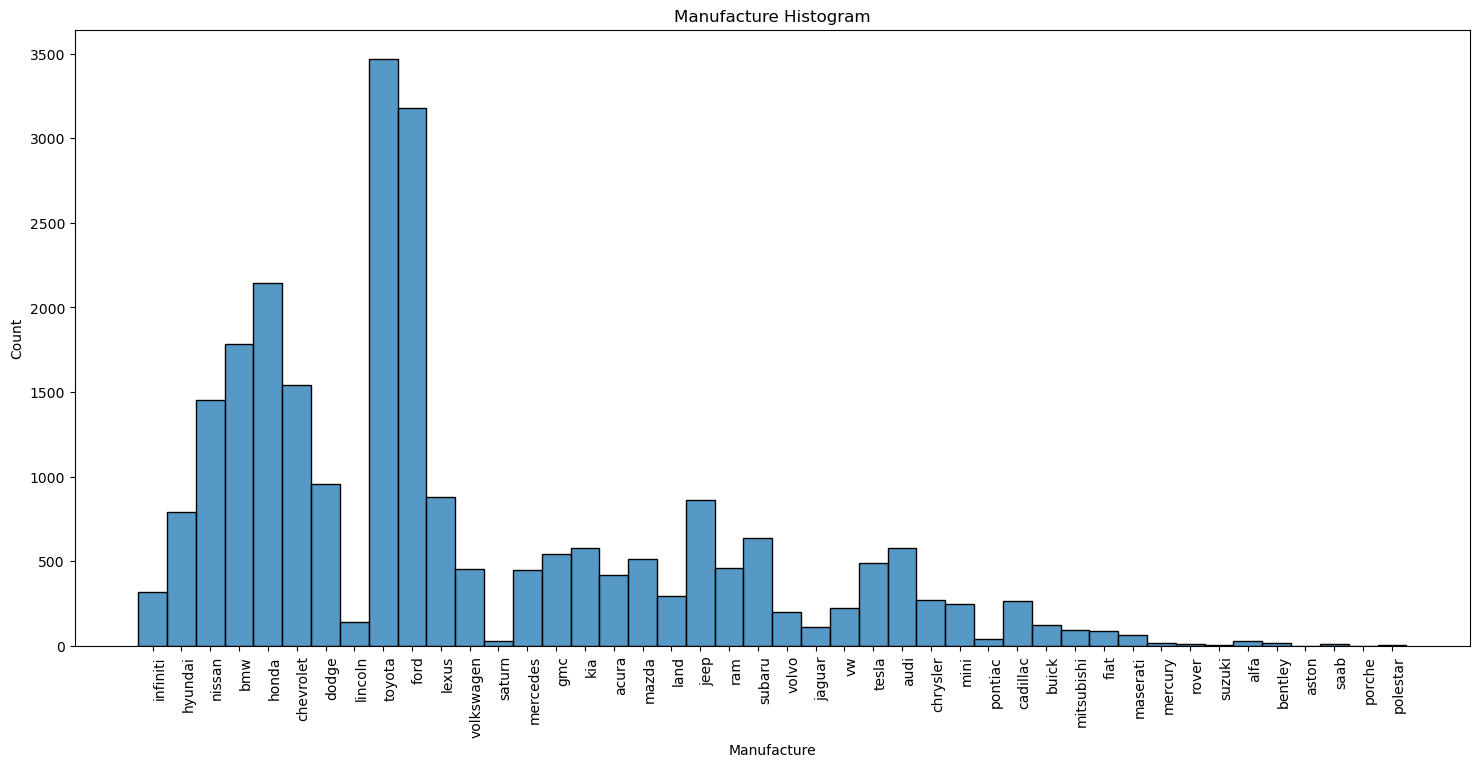

In [31]:
fig, ax = plt.subplots(figsize=(18,8))

fg = sns.histplot(df1['manufacture'], ax=ax)

fg.set_title("Manufacture Histogram")

fg.set_xlabel("Manufacture")

plt.xticks(rotation=90, ha='right', rotation_mode = 'anchor')

plt.show()  # count of car maufacturers:

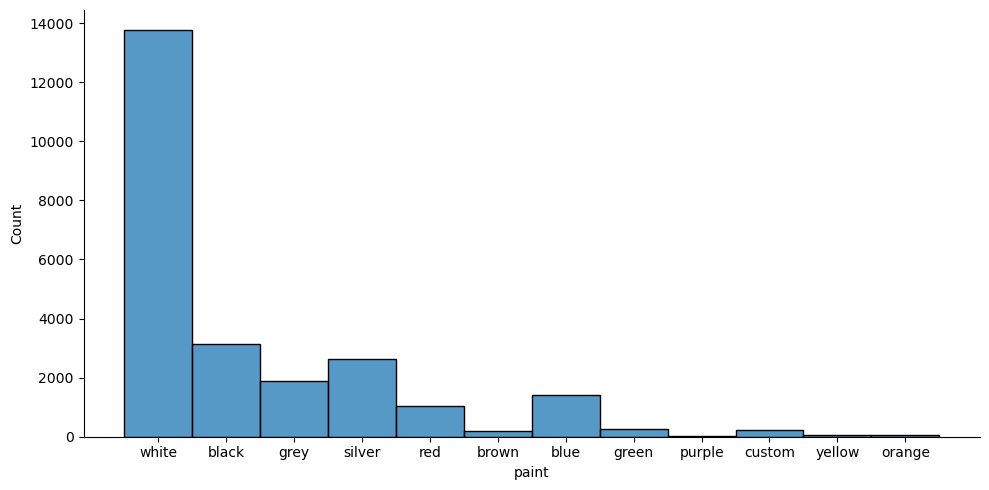

In [109]:
sns.displot(df1, x="paint", height=5, aspect=2) # white is the most dominant color:

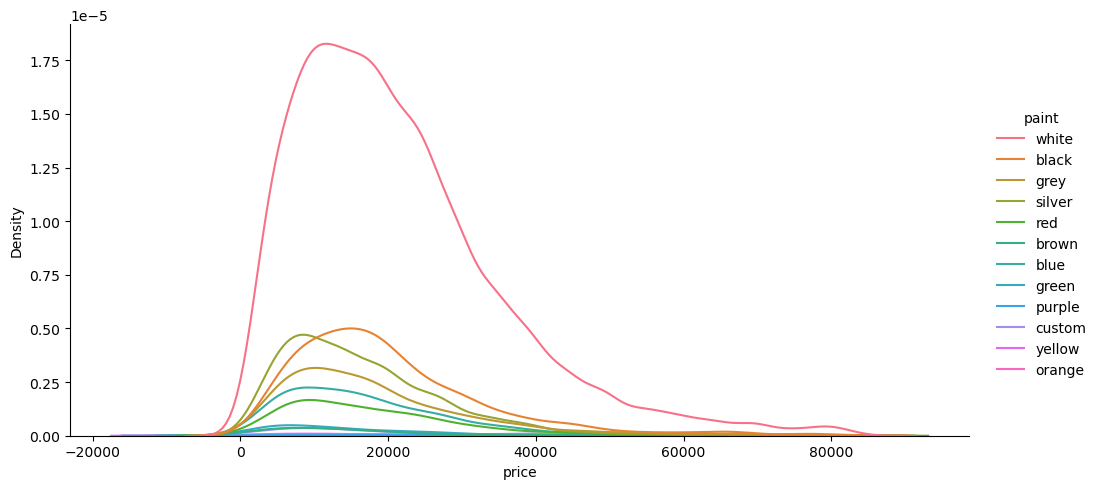

In [110]:
# price vs number of cars plot:

sns.displot( data= df1, x = "price" , hue="paint", kind="kde" , aspect = 2)

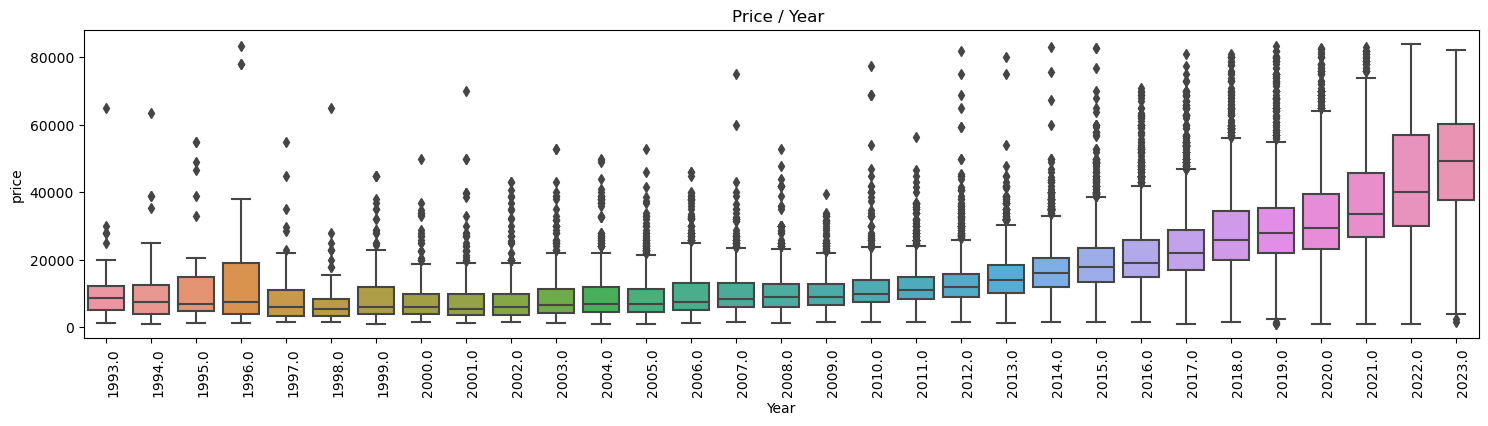

In [111]:
# boxplot featuring year and price

fig, ax = plt.subplots(figsize=(18,4))

fg = sns.boxplot(data=df1, x='year',y='price')

fg.set_title("Price / Year ")

fg.set_xlabel("Year")

fg.set_ylabel("price")

plt.xticks(rotation=90, ha='right', rotation_mode = 'anchor')

plt.show()

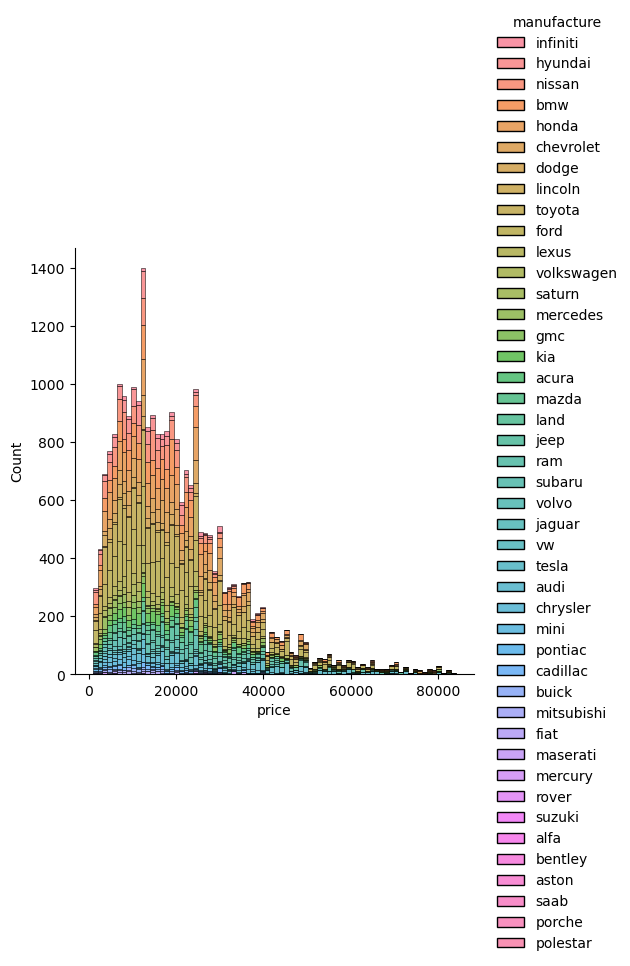

In [112]:
# distribution plot showing the correspondence between car manufactureres , their prices and the count of each priced car

sns.displot(df1, x="price", hue='manufacture', multiple="stack")

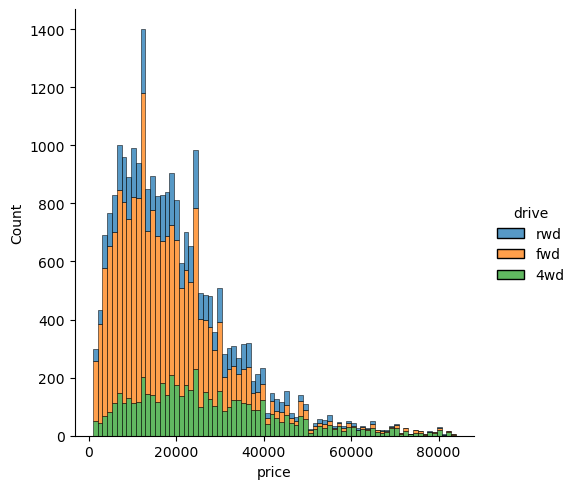

In [113]:
sns.displot(df1, x="price", hue='drive', multiple="stack")

In [98]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24730 entries, 2 to 25910
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          24730 non-null  float64
 1   odometer      24730 non-null  float64
 2   cylinders     24730 non-null  float64
 3   fuel          24730 non-null  float64
 4   manufacture   24730 non-null  object 
 5   drive         24730 non-null  object 
 6   paint         24730 non-null  object 
 7   price         24730 non-null  float64
 8   transmission  24730 non-null  float64
dtypes: float64(6), object(3)
memory usage: 1.9+ MB


In [99]:
# we can understand that  ,cars in which the drive is "fwd" are the least expensive ones , hence , drive column is crucial to our regression 

In [100]:
df1 = df1.reset_index(drop=True)

<AxesSubplot:>

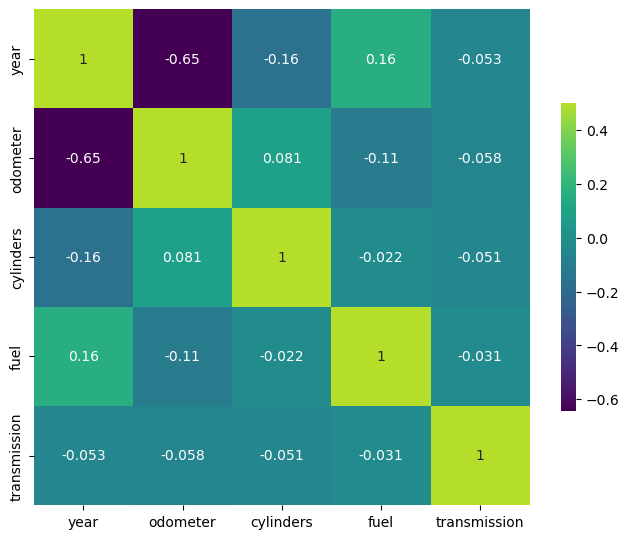

In [101]:
# let's see the corralation between our columns:

corr_2 = df1.drop(columns = ['price']).corr()

f, ax = plt.subplots(figsize = ( 8,8))

cmap = sns.color_palette("viridis" , as_cmap = True)

sns.heatmap( corr_2 , cmap = cmap , vmax = .5 , center = 0 , square = True , cbar_kws= {"shrink": .5} , annot = True)

In [102]:
# we will try to perform several machine learning models on our data , lets start with Linear Regression:
# we will transform the categorical columns using get dummies fucntion

df_reg = df1.copy()
df_reg.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24730 entries, 0 to 24729
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          24730 non-null  float64
 1   odometer      24730 non-null  float64
 2   cylinders     24730 non-null  float64
 3   fuel          24730 non-null  float64
 4   manufacture   24730 non-null  object 
 5   drive         24730 non-null  object 
 6   paint         24730 non-null  object 
 7   price         24730 non-null  float64
 8   transmission  24730 non-null  float64
dtypes: float64(6), object(3)
memory usage: 1.7+ MB


In [104]:
df_reg= pd.get_dummies( df_reg , columns = df_reg.select_dtypes(include=["object", "category"]).columns.tolist() , drop_first=True,)



In [105]:
df_reg

,year,odometer,cylinders,fuel,price,transmission,manufacture_alfa,manufacture_aston,manufacture_audi,manufacture_bentley,...,paint_brown,paint_custom,paint_green,paint_grey,paint_orange,paint_purple,paint_red,paint_silver,paint_white,paint_yellow
0,2015.0,94933.0,6.0,0.0,17995.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2017.0,64265.0,4.0,0.0,11995.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2018.0,39101.0,4.0,0.0,16495.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2017.0,93702.0,4.0,0.0,13999.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2016.0,84285.0,4.0,0.0,15000.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24725,2014.0,110416.0,4.0,0.0,15988.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
24726,2021.0,4116.0,4.0,0.0,17455.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24727,2008.0,124064.0,4.0,0.0,13999.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24728,2007.0,200009.0,4.0,0.0,6400.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [106]:
# now we can find the best regression model

from sklearn import metrics

from sklearn.model_selection import train_test_split

from sklearn.metrics import make_scorer

from sklearn.metrics import r2_score

from sklearn.metrics import f1_score

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import LabelEncoder


In [114]:
# taking all columns except for the price column

df_reg  = df_reg.reindex(columns = [col for col in df_reg.columns if col != 'price'] + ['price'])

X = df_reg.iloc[:,:-1]

y = df_reg.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.3, random_state=42)

scaler = StandardScaler() 


In [115]:
scaler.fit_transform(X_train) # fitting the scaler
scaler.transform(X_test)

array([[-2.92580529,  3.09447387,  1.81844637, ..., -0.34601782,
         0.89382283, -0.04872432],
       [-0.21024385, -0.00955031,  0.51011424, ..., -0.34601782,
         0.89382283, -0.04872432],
       [ 0.29892392,  0.8797394 ,  0.51011424, ..., -0.34601782,
        -1.11878995, -0.04872432],
       ...,
       [ 0.8080917 ,  0.42315343,  0.51011424, ...,  2.89002457,
        -1.11878995, -0.04872432],
       [ 0.12920133, -0.28620756,  1.81844637, ..., -0.34601782,
        -1.11878995, -0.04872432],
       [-2.07719234,  0.41833639,  1.81844637, ..., -0.34601782,
         0.89382283, -0.04872432]])

In [116]:
#linear machine learning option  evaluates the score:

clf_model = LinearRegression().fit(X_train, y_train)

y_predicted = clf_model.predict(X_test)

In [117]:
evaluate_value = r2_score(y_test,y_predicted)

evaluate_value

0.6310403016611648

In [125]:
# 0.63 for the linear regression 

In [119]:

#let's see if the Random Forest Regressor provides a better score:

# we can use the same X, y , and so on variables on the Random Forest Regressor


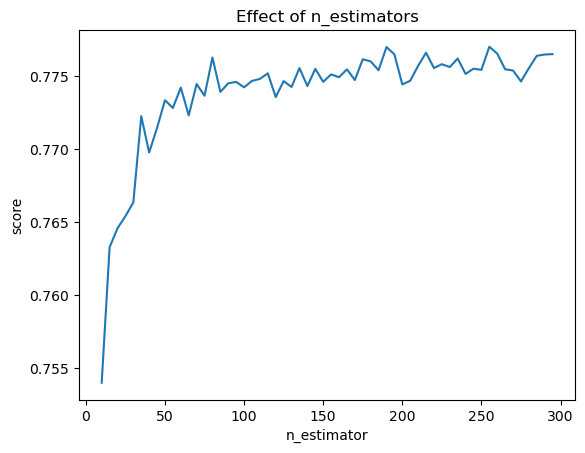

In [120]:
# we will normalize all the values and perform the Random Forest Regression on the data :

scaler = StandardScaler() 

scaler.fit(X_train) # fitting the scaler

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

model = RandomForestRegressor(n_jobs=-1)

estimators = np.arange(10, 300, 5)

scores = []

# using a simple plot , we can see what is the number of n estimators which is best :

maximum_n_esimators = -1

max_score = -1

for n in estimators:

    model.set_params(n_estimators=n)
    
    model.fit(X_train, y_train)
    
    scores.append(model.score(X_test, y_test))
    
    
    current_score = model.score(X_test, y_test)  # keeping the best result
    
    if current_score > max_score:
        
        maximum_n_esimators = n
        
        max_score = current_score

    
    
# # we can also see the effect of n_estimators on the score of the trained model 
    
plt.title("Effect of n_estimators")

plt.xlabel("n_estimator")

plt.ylabel("score")

plt.plot(estimators, scores)   

In [121]:
print( "The max score is:" , max_score , " and the optimal number of n estimators is:", maximum_n_esimators)

The max score is: 0.7770123165567577  and the optimal number of n estimators is: 255


In [123]:
#as shown above , the best n estimators value is around 105 , and so we shall use it 

model.set_params(n_estimators=255)
    
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=255, n_jobs=-1)

In [124]:
y_pred = model.predict(X_test)

print("the test Y in comparison to the predicted Y is : " , metrics.r2_score(y_test,y_pred))


the test Y in comparison to the predicted Y is :  0.7762290802450197


In [148]:
ecv = f1_score( y_test, y_pred  )

array([16299.86133333, 14228.62      , 15935.312     , ...,
       36354.5       , 19120.304     ,  7491.584     ])

In [ ]:
# that's better now - 0.775 score

In [431]:
# using the grid search CV on the model:

parameters = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [25],
}

forest = RandomForestRegressor()

clf = GridSearchCV(forest, parameters,cv=10)

clf.fit(X_train,y_train)

y_pred_train = clf.predict(X_train)

y_pred = clf.predict(X_test)

print("best parameter is: ", clf.best_params_, " and the score was :" ,clf.best_score_)

best parameter is:  {'max_depth': 25, 'n_estimators': 200}  and the score was : 0.7479524509735862


In [432]:
# scoring according to r2 score :

scores2 = []

forest = RandomForestRegressor(n_estimators=246, random_state=42)

acc = cross_val_score(forest, X_test, y_test, scoring='r2', cv=10)

scores2.append(round(acc.mean()*100,2))

In [433]:
results = pd.DataFrame({'Metrics': ['accuracy'], 'Accuracy' : scores2})

results

,Metrics,Accuracy
0,accuracy,71.73


In [ ]:
To sum up :

The best regression model we have used was the random forest Regressor , which provided a 0.77 score 

we have learned that the most common car color is ( not so surprising ) "white" 

the most common drive is front wheel 

and that the most advertised car manufacturer is Toyota ( first by a small margin to the native American Ford company )

